In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import easyocr

# import os,sys
# from paddleocr import PaddleOCR, draw_ocr

In [2]:
# Specify language to identify from images
reader = easyocr.Reader(['en','nl'], gpu = False)

Using CPU. Note: This module is much faster with a GPU.


In [3]:
# Load images
images = [cv2.imread(file) for file in glob.glob("Data/StreetSwipe/images_classified/*/*.jpg")]
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images] # correct the color channel
print(f"Total number of images: {len(images)}")

Total number of images: 2441


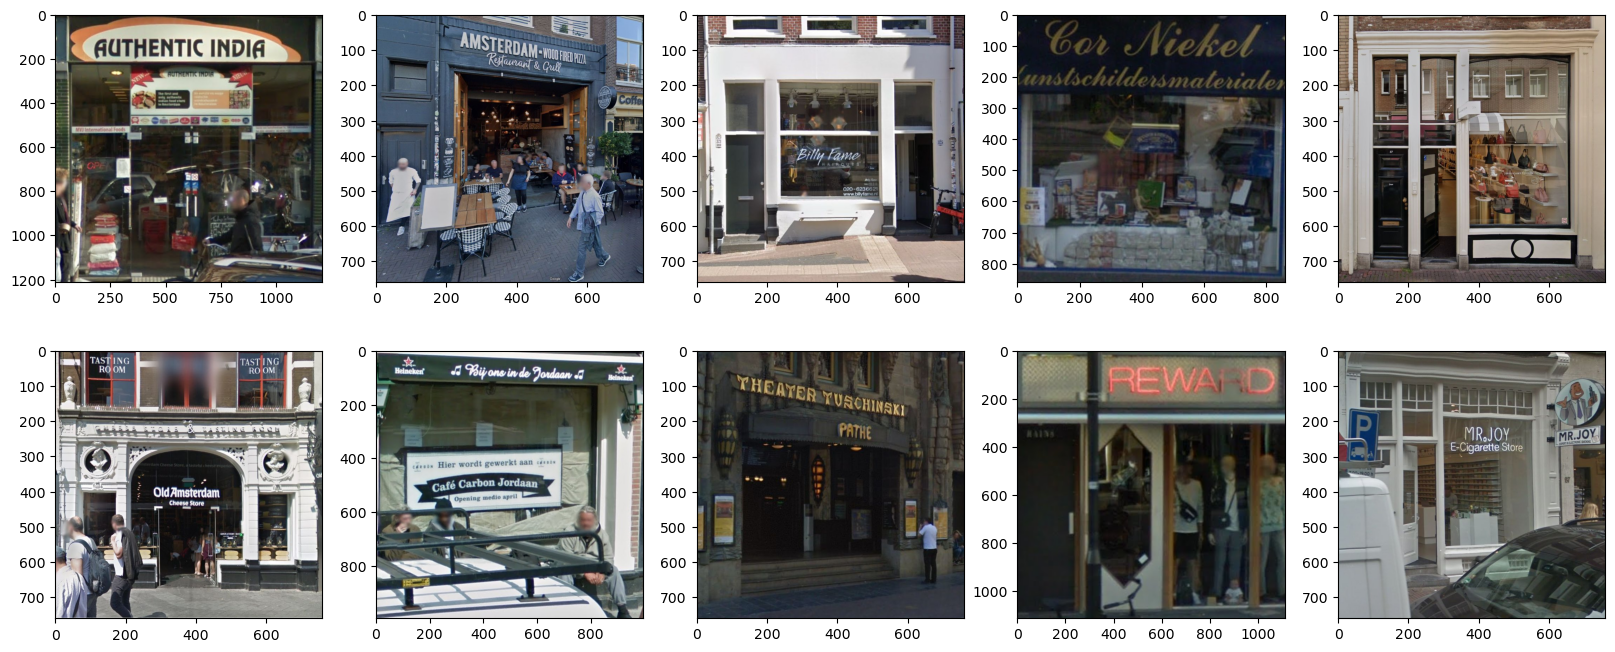

In [12]:
# Sample image
test_imgs = [images[i] for i in np.random.randint(2441, size =(10))]

# plt.figure(figsize=(10,10))
# plt.imshow(test_img)
# plt.show()

fig = plt.figure(figsize=(20,8))
rows, cols = 2, 5

for i in range(0, cols*rows):
  fig.add_subplot(rows, cols, i+1)
  plt.imshow(test_imgs[i])
plt.show()

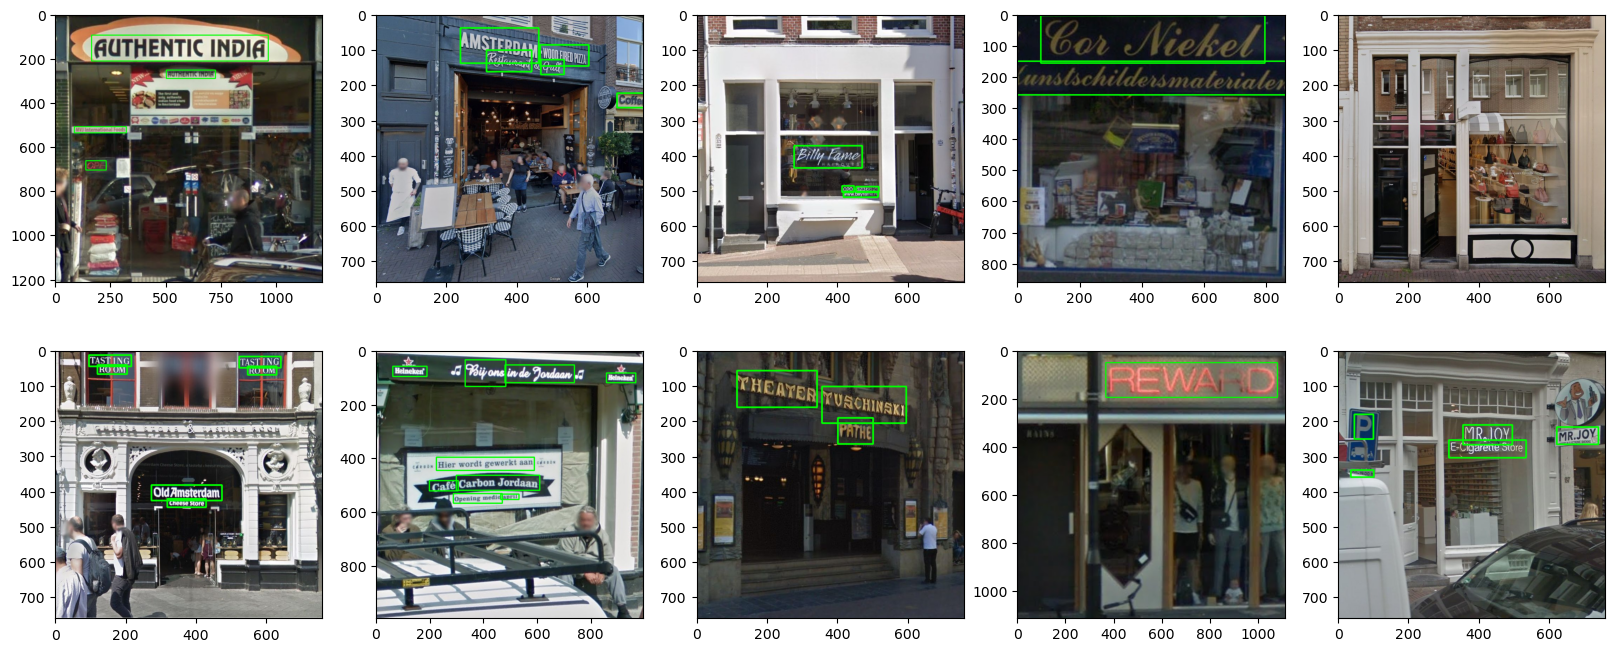

In [13]:
fig = plt.figure(figsize=(20,8))
rows, cols = 2, 5

for i in range(0, cols*rows):
    fig.add_subplot(rows, cols, i+1)

    result = reader.detect(test_imgs[i], text_threshold=0.9)

    result_vis = test_imgs[i]
    spacer = 100

    for box in result[0][0]: 
        top_left = (box[0], box[2])
        bottom_right = (box[1], box[3])
        result_vis = cv2.rectangle(result_vis,top_left,bottom_right,(0,255,0),3)
        spacer+=15

    for box in result[1][0]: 
        top_left = tuple(int(i) for i in box[0])
        bottom_right = tuple(int(i) for i in box[2])
        result_vis = cv2.rectangle(result_vis,top_left,bottom_right,(0,255,0),3)
        spacer+=15

    plt.imshow(result_vis)
plt.show()

([[[172, 285, 192, 265]]],
 [[[[605.3026573907705, 144.04886747447082],
    [696.9960047936089, 186.80015980825564],
    [678.6973426092295, 224.95113252552918],
    [587.0039952063911, 183.19984019174436]]]])

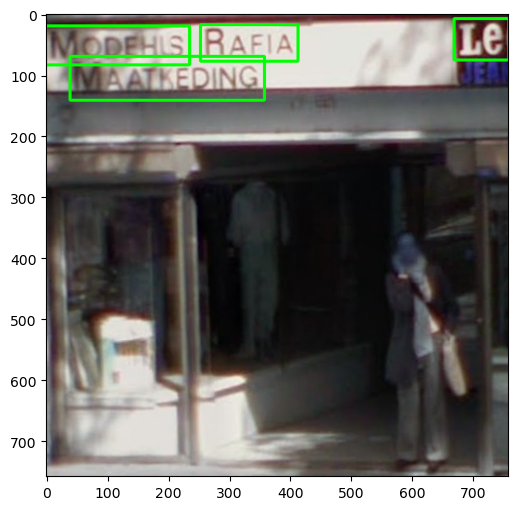

In [51]:
# result_vis = test_img
# spacer = 100

# for detection in result[0][0]: 
#     top_left = (box[0], box[2])
#     bottom_right = (box[1], box[3])
#     result_vis = cv2.rectangle(result_vis,top_left,bottom_right,(0,255,0),3)
#     spacer+=15

# for detection in result[1][0]: 
#     top_left = tuple(int(i) for i in detection[0])
#     bottom_right = tuple(int(i) for i in detection[2])
#     result_vis = cv2.rectangle(result_vis,top_left,bottom_right,(0,255,0),3)
#     spacer+=15

# plt.figure(figsize=(6,6))
# plt.imshow(result_vis)
# plt.show()